In [ ]:
pip install openai pillow matplotlib

In [ ]:
pip install python-dotenv

In [ ]:
# 2. 라이브러리 임포트 및 OpenAI API 키 설정
import openai
from openai import OpenAI # import openai
import cv2
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw
import io
import json
import ast
import base64
from dotenv import load_dotenv
from pathlib import Path
import os

In [ ]:
# `.env` 파일의 경로 설정 (업로드한 파일 이름으로 변경)
dotenv_path = Path('/content/.env')  # 업로드한 파일 이름이 '.env'인 경우

# `.env` 파일 로드
load_dotenv(dotenv_path=dotenv_path)

# 환경 변수에서 API 키 가져오기
openai_api_key = os.getenv('OPENAI_API_KEY')

# API 키가 제대로 로드되었는지 확인
if openai_api_key is None:
    raise ValueError("OPENAI_API_KEY가 환경 변수에 설정되지 않았습니다. `.env` 파일을 확인하세요.")
else:
    print("OpenAI API 키가 성공적으로 로드되었습니다.")

OpenAI API 키가 성공적으로 로드되었습니다.


In [ ]:
# 이미지를 base64로 인코딩하고 PIL 이미지 객체를 반환하는 함수
def load_and_encode_images(image_sources):
    encoded_images = []
    pil_images = []
    for source in image_sources:
      with open(source, "rb") as image_file:
        image_data = image_file.read()

        pil_images.append(Image.open(io.BytesIO(image_data)))
        encoded_images.append(base64.b64encode(image_data).decode('utf-8'))
    return encoded_images, pil_images

In [ ]:
# 응답결과와 이미지를 출력하기 위한 함수
def display_response(pil_images, response_text):
    # 이미지 로딩 및 서브플롯 생성
    fig, axes = plt.subplots(nrows=1, ncols=len(pil_images), figsize=(5 * len(pil_images), 5))
    if len(pil_images) == 1:  # 하나의 이미지인 경우
        axes = [axes]

    # 이미지들 표시
    for i, img in enumerate(pil_images):
        axes[i].imshow(img)
        axes[i].axis('off')  # 축 정보 숨기기
        axes[i].set_title(f'Image #{i+1}')

    # 전체 플롯 표시
    plt.show()

    print(response_text)

In [ ]:
# 이미지 경로 또는 URL과 프롬프트를 처리하는 함수
def process_and_display_images(image_sources, prompt):
    # 이미지 로드, base64 인코딩 및 PIL 이미지 객체 생성
    base64_images, pil_images = load_and_encode_images(image_sources)
    client = OpenAI()

    # OpenAI에 요청 보내기
    messages = [
        {
            "role": "user",
            "content": [
                {"type": "text", "text": prompt}
            ] + [{"type": "image_url", "image_url": {"url": f"data:image/jpeg;base64,{base64_image}"}} for base64_image in base64_images]
        }
    ]

    response = client.chat.completions.create(
        model="gpt-4o-mini",
        messages=messages,
        max_tokens=1000
    )

    response_text = response.choices[0].message.content

    # 응답과 이미지 표시
    display_response(pil_images, response.choices[0].message.content)

    return response_text

In [ ]:
image_sources = ["/content/img_bene_car.png"]

In [ ]:
prompt = "Can you tell me the location of the car on the image, very accurately, ensuring that the area covers the entire object (car). Share the x_min, y_min, x_max, y_max in 0-1 normalized space. Only return the numbers, nothing else."

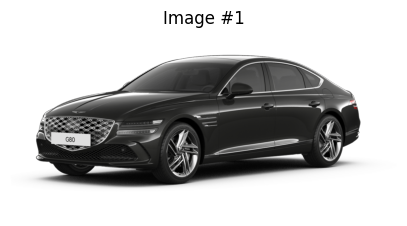

0.15, 0.2, 0.85, 0.75


In [ ]:
response_text = process_and_display_images(image_sources, prompt)

In [ ]:
x_min, y_min, x_max, y_max = [float(value.strip()) for value in response_text.split(',')]

img = Image.open("/content/img_bene_car.png")
width, height = img.size

In [ ]:
# 경계 상자 좌표 계산
tlX = int(x_min * width)
tlY = int(y_min * height)
brX = int(x_max * width)
brY = int(y_max * height)

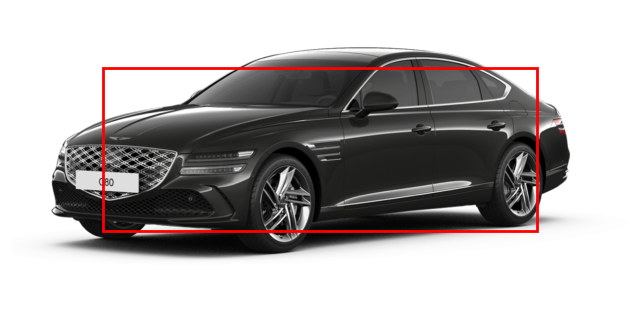

In [ ]:
# 이미지 표시 및 경계 상자 그리기
plt.figure(figsize=(8, 6))
plt.imshow(img)
plt.gca().add_patch(plt.Rectangle((tlX, tlY), brX-tlX, brY-tlY, edgecolor='red', linewidth=2, fill=False))
plt.axis('off')
plt.show()

# 모듈화

In [ ]:
# image_processing/load_and_encode_images.py

import base64
import io
from PIL import Image

def load_and_encode_images(image_sources):
    """이미지 경로 리스트를 받아 base64 인코딩된 문자열 리스트와 PIL Image 객체 리스트를 반환하는 함수."""
    encoded_images = []
    pil_images = []
    for source in image_sources:
        with open(source, "rb") as image_file:
            image_data = image_file.read()
            pil_img = Image.open(io.BytesIO(image_data))
            pil_images.append(pil_img)
            encoded_images.append(base64.b64encode(image_data).decode('utf-8'))
    return encoded_images, pil_images


In [ ]:
# image_processing/display_response.py

import matplotlib.pyplot as plt

def display_response(pil_images, response_text):
    """응답 결과를 출력하고 PIL 이미지 리스트를 서브플롯으로 표시하는 함수."""
    fig, axes = plt.subplots(nrows=1, ncols=len(pil_images), figsize=(5 * len(pil_images), 5))
    if len(pil_images) == 1:
        axes = [axes]

    for i, img in enumerate(pil_images):
        axes[i].imshow(img)
        axes[i].axis('off')
        axes[i].set_title(f'Image #{i+1}')
    plt.show()

    print(response_text)


In [ ]:
# image_processing/convert_rgb_to_bgr.py

import numpy as np
from PIL import Image

def convert_rgb_to_bgr(pil_img):
    """PIL RGB 이미지를 BGR 채널 순서로 변경한 뒤 다시 PIL 이미지로 반환하는 함수."""
    rgb_array = np.array(pil_img)
    bgr_array = rgb_array[:, :, ::-1]
    img_bgr = Image.fromarray(bgr_array, 'RGB')
    return img_bgr


In [ ]:
# image_processing/draw_bounding_box_on_image.py

import matplotlib.pyplot as plt

def draw_bounding_box_on_image(img, x_min, y_min, x_max, y_max):
    """정규화된 좌표를 이용해 이미지에 bounding box를 그려주는 함수."""
    width, height = img.size
    tlX = int(x_min * width)
    tlY = int(y_min * height)
    brX = int(x_max * width)
    brY = int(y_max * height)

    plt.figure(figsize=(8, 6))
    plt.imshow(img)
    plt.gca().add_patch(
        plt.Rectangle((tlX, tlY), brX - tlX, brY - tlY,
                      edgecolor='red', linewidth=2, fill=False)
    )
    plt.axis('off')
    plt.show()


In [ ]:
# image_processing/process_and_display_images.py

import base64
import os
from PIL import Image
import matplotlib.pyplot as plt

from .load_and_encode_images import load_and_encode_images
from .display_response import display_response

def process_and_display_images(image_sources, prompt, openai_client):
    """이미지를 로드, OpenAI API 요청, 응답을 받고 결과 표시."""
    base64_images, pil_images = load_and_encode_images(image_sources)

    messages = [
        {
            "role": "user",
            "content": [
                {"type": "text", "text": prompt}
            ] + [
                {
                    "type": "image_url",
                    "image_url": {"url": f"data:image/jpeg;base64,{base64_image}"}
                }
                for base64_image in base64_images
            ]
        }
    ]

    response = openai_client.chat.completions.create(
        model="gpt-4o-mini",
        messages=messages,
        max_tokens=1000
    )

    response_text = response.choices[0].message.content
    display_response(pil_images, response_text)

    return pil_images, response_text


In [ ]:
# main.py

import os
from dotenv import load_dotenv
import openai

# 작성한 모듈 임포트
from image_processing.process_and_display_images import process_and_display_images
from image_processing.draw_bounding_box_on_image import draw_bounding_box_on_image

# 환경 변수 로드 (OPENAI_API_KEY 등)
load_dotenv()

openai.api_key = os.getenv("OPENAI_API_KEY")

# OpenAI 클라이언트 객체 생성
# OpenAI의 최신 라이브러리에서는 클라이언트 객체를 따로 생성하지 않고, 바로 API를 호출합니다.
# 따라서, 아래와 같이 수정이 필요할 수 있습니다.
# 예시:
# response = openai.ChatCompletion.create(...)

# 처리할 이미지 및 프롬프트 정의
image_sources = ["./content/img_bene_car.png"]  # 경로 수정 필요
prompt = "Can you tell me the location of the car on the image, very accurately, ensuring that the area covers the entire object (car). Share the x_min, y_min, x_max, y_max in 0-1 normalized space. Only return the numbers, nothing else."

# 이미지를 처리하고 결과를 받아오기
pil_images, response_text = process_and_display_images(image_sources, prompt, openai)

# 응답으로부터 경계 상자 좌표 파싱
try:
    x_min, y_min, x_max, y_max = [float(value.strip()) for value in response_text.split(',')]
except ValueError:
    print("응답 형식이 올바르지 않습니다:", response_text)
    exit(1)

# 첫 번째 이미지에 대해 bounding box 그리기 (여러 이미지라면 반복하거나 인덱스로 접근)
draw_bounding_box_on_image(pil_images[0], x_min, y_min, x_max, y_max)


In [ ]:
import os
import cv2
import mediapipe as mp
import numpy as np
from typing import List, Dict

# Mediapipe 솔루션 초기화 (전역적으로 한 번만 수행)
mp_pose = mp.solutions.pose
mp_face = mp.solutions.face_mesh
mp_hands = mp.solutions.hands

pose = mp_pose.Pose(static_image_mode=False, min_detection_confidence=0.5, min_tracking_confidence=0.5)
face_mesh = mp_face.FaceMesh(static_image_mode=False, max_num_faces=1, min_detection_confidence=0.5, min_tracking_confidence=0.5)
hands = mp_hands.Hands(static_image_mode=False, max_num_hands=2, min_detection_confidence=0.5, min_tracking_confidence=0.5)


def calculate_lack_of_eye_contact_score(face_landmarks, frame_width):
    """
    발표자의 시선 부족 정도를 점수로 반환합니다.

    Args:
        face_landmarks: Mediapipe FaceMesh 랜드마크.
        frame_width: 프레임 너비.

    Returns:
        float: 시선 부족 점수 (0에서 1 사이).
    """
    LEFT_EYE = 33
    RIGHT_EYE = 263

    # 왼쪽/오른쪽 눈의 x좌표 구하기
    left_eye_x = face_landmarks.landmark[LEFT_EYE].x * frame_width
    right_eye_x = face_landmarks.landmark[RIGHT_EYE].x * frame_width

    # 화면 중앙 범위 설정
    center_min = 0.4 * frame_width
    center_max = 0.6 * frame_width

    # 눈 위치가 화면 중앙에서 얼마나 벗어났는지 계산
    left_deviation = max(center_min - left_eye_x, left_eye_x - center_max, 0)
    right_deviation = max(center_min - right_eye_x, right_eye_x - center_max, 0)

    # 편차를 정규화하여 점수 환산
    gaze_score = (left_deviation + right_deviation) / frame_width
    return min(gaze_score / 0.1, 1.0)


def calculate_excessive_gestures_score(hand_landmarks):
    """
    과도한 손동작 정도를 점수로 반환합니다. (엄지와 검지 끝 랜드마크 거리로 예측)

    Args:
        hand_landmarks: Mediapipe Hands 랜드마크.

    Returns:
        float: 과도한 제스처 점수 (0에서 1 사이).
    """
    THUMB_TIP = mp_hands.HandLandmark.THUMB_TIP.value
    INDEX_TIP = mp_hands.HandLandmark.INDEX_FINGER_TIP.value

    # 엄지 끝, 검지 끝 랜드마크 좌표
    thumb_tip = hand_landmarks.landmark[THUMB_TIP]
    index_tip = hand_landmarks.landmark[INDEX_TIP]

    # 두 점 사이의 거리
    distance = np.sqrt((thumb_tip.x - index_tip.x) ** 2 + (thumb_tip.y - index_tip.y) ** 2)

    # 0.2를 기준으로 1까지 정규화
    return min(distance / 0.2, 1.0)


def calculate_hand_movement_score(current_hand_landmarks, previous_hand_landmarks, threshold=0.1):
    """
    현재 프레임과 이전 프레임에서 손목 위치 변화로 움직임 점수를 계산합니다.

    Args:
        current_hand_landmarks: 현재 프레임의 Mediapipe HandLandmarks 객체.
        previous_hand_landmarks: 이전 프레임의 Mediapipe HandLandmarks 객체.
        threshold: 움직임 점수 계산 기준이 되는 임계값.

    Returns:
        float: 움직임 점수 (0에서 1 사이).
    """
    if previous_hand_landmarks is None:
        # 이전 프레임 정보가 없으면 움직임 점수를 0으로 반환
        return 0.0

    WRIST = mp_hands.HandLandmark.WRIST.value
    current_wrist = current_hand_landmarks.landmark[WRIST]
    previous_wrist = previous_hand_landmarks.landmark[WRIST]

    # 손목의 이동 거리 계산
    movement_distance = np.sqrt((current_wrist.x - previous_wrist.x)**2 + (current_wrist.y - previous_wrist.y)**2)
    # threshold 대비 비율로 점수 환산
    movement_score = min(movement_distance / threshold, 1.0)
    return movement_score


def is_hand_out_of_frame(hand_landmarks, frame_width, frame_height):
    """
    손이 화면 밖에 위치하는지 여부를 판단합니다.

    Args:
        hand_landmarks: Mediapipe HandLandmarks 객체.
        frame_width: 프레임의 너비.
        frame_height: 프레임의 높이.

    Returns:
        bool: 손이 화면 밖이면 True, 아니면 False.
    """
    for landmark in hand_landmarks.landmark:
        x, y = landmark.x * frame_width, landmark.y * frame_height
        if x < 0 or x > frame_width or y < 0 or y > frame_height:
            return True
    return False


def calculate_head_position_score(pose_landmarks, frame_width, frame_height):
    """
    머리(코 위치)의 X, Y 편차로 자세 점수를 계산합니다.

    Args:
        pose_landmarks: Mediapipe Pose 랜드마크.
        frame_width: 프레임 너비.
        frame_height: 프레임 높이.

    Returns:
        float: 자세 점수 (0: 좋음 ~ 1: 나쁨).
    """
    NOSE = mp_pose.PoseLandmark.NOSE.value
    nose_x = pose_landmarks.landmark[NOSE].x * frame_width
    nose_y = pose_landmarks.landmark[NOSE].y * frame_height

    # 화면 중심
    center_x, center_y = frame_width / 2, frame_height / 2

    # X, Y 축 편차 계산
    x_distance = abs(nose_x - center_x)
    y_distance = abs(nose_y - center_y)

    # 최대 허용 거리(정상 자세 범위)
    max_x_distance = frame_width * 0.1
    max_y_distance = frame_height * 0.2

    # X, Y 편차를 정규화하여 점수 계산
    x_score = min(x_distance / max_x_distance, 1.0)
    y_score = min(y_distance / max_y_distance, 1.0)

    # X, Y 평균
    posture_score = (x_score + y_score) / 2
    return posture_score


def calculate_sudden_movement_score(pose_landmarks, previous_pose_landmarks, threshold=0.1):
    """
    갑작스러운 움직임 정도를 점수로 반환합니다.
    어깨와 엉덩이의 평균 위치 변화로 추정.

    Args:
        pose_landmarks: 현재 프레임의 포즈 랜드마크.
        previous_pose_landmarks: 이전 프레임의 포즈 랜드마크.
        threshold: 움직임 감지 임계값.

    Returns:
        float: 갑작스러운 움직임 점수 (0에서 1 사이).
    """
    if previous_pose_landmarks is None:
        return 0.0

    def get_center(landmarks, points):
        x = np.mean([landmarks.landmark[p].x for p in points])
        y = np.mean([landmarks.landmark[p].y for p in points])
        return np.array([x, y])

    # 상체 중심 (양 어깨, 양 엉덩이 평균 좌표)
    current_center = get_center(pose_landmarks, [
        mp_pose.PoseLandmark.LEFT_SHOULDER.value,
        mp_pose.PoseLandmark.RIGHT_SHOULDER.value,
        mp_pose.PoseLandmark.LEFT_HIP.value,
        mp_pose.PoseLandmark.RIGHT_HIP.value
    ])
    previous_center = get_center(previous_pose_landmarks, [
        mp_pose.PoseLandmark.LEFT_SHOULDER.value,
        mp_pose.PoseLandmark.RIGHT_SHOULDER.value,
        mp_pose.PoseLandmark.LEFT_HIP.value,
        mp_pose.PoseLandmark.RIGHT_HIP.value
    ])

    # 현재 상체 중심과 이전 상체 중심 사이의 이동 거리
    movement = np.linalg.norm(current_center - previous_center)
    return min(movement / threshold, 1.0)


def draw_debug_info(frame, pose_landmarks, frame_width, frame_height, posture_score):
    """
    디버깅을 위한 시각화 함수. 코 위치와 화면 중심선을 표시하고 자세 점수를 보여줍니다.

    Args:
        frame: OpenCV 프레임.
        pose_landmarks: Mediapipe Pose 랜드마크.
        frame_width: 프레임 너비.
        frame_height: 프레임 높이.
        posture_score: 계산된 자세 점수.
    """
    NOSE = mp_pose.PoseLandmark.NOSE.value
    nose_x = int(pose_landmarks.landmark[NOSE].x * frame_width)
    nose_y = int(pose_landmarks.landmark[NOSE].y * frame_height)

    # 머리(코) 위치 표시
    cv2.circle(frame, (nose_x, nose_y), 5, (0, 255, 0), -1)

    # 화면 중심선 그리기
    center_x, center_y = frame_width // 2, frame_height // 2
    cv2.line(frame, (center_x, 0), (center_x, frame_height), (255, 0, 0), 2)
    cv2.line(frame, (0, center_y), (frame_width, center_y), (255, 0, 0), 2)

    # 자세 점수 표시
    cv2.putText(frame, f"Posture Score: {posture_score:.2f}", (10, 30),
                cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)

    # 자세가 매우 나쁘다면 추가 메시지
    if posture_score > 0.7:
        cv2.putText(frame, "Poor Posture", (10, 60),
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 255), 2)


def draw_text(frame, text, x, y, color=(0, 255, 0)):
    """
    프레임 위에 텍스트를 그립니다.

    Args:
        frame: OpenCV 프레임
        text: 표시할 텍스트
        x, y: 텍스트 좌표
        color: 텍스트 색상 (BGR)
    """
    cv2.putText(frame, text, (x, y), cv2.FONT_HERSHEY_SIMPLEX, 1, color, 2)


def analyze_frame(frame, previous_pose_landmarks, previous_hand_landmarks,
                  posture_threshold=0.5, gaze_threshold=0.5, gesture_threshold=0.5,
                  movement_threshold=0.5, hand_movement_threshold=0.5):
    """
    단일 프레임을 분석하여 자세, 시선, 손동작 등의 피드백 정보를 반환합니다.

    Args:
        frame: 분석할 OpenCV 프레임
        previous_pose_landmarks: 이전 프레임의 포즈 랜드마크
        previous_hand_landmarks: 이전 프레임의 손 랜드마크
        posture_threshold: 자세 불량 판정 기준 점수
        gaze_threshold: 시선 부족 판정 기준 점수
        gesture_threshold: 손 제스처 과도 판정 기준 점수
        movement_threshold: 갑작스런 움직임 판정 기준 점수
        hand_movement_threshold: 손 움직임 과도 판정 기준 점수

    Returns:
        feedback: 분석 결과를 담은 딕셔너리
        current_pose_landmarks: 현재 포즈 랜드마크
        current_hand_landmarks: 현재 손 랜드마크
    """
    frame_height, frame_width, _ = frame.shape
    rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

    # Mediapipe 결과 처리
    pose_results = pose.process(rgb_frame)
    face_results = face_mesh.process(rgb_frame)
    hand_results = hands.process(rgb_frame)

    # 초기 점수들
    posture_score = 0
    gaze_score = 0
    excessive_gestures_score = 0
    sudden_movement_score = 0
    hand_out_of_frame_flag = False
    hand_movement_score = 0

    current_pose_landmarks = None
    current_hand_landmarks = None

    # 포즈 분석
    if pose_results.pose_landmarks:
        current_pose_landmarks = pose_results.pose_landmarks
        # 여기서 frame_width, frame_height 순서에 맞게 전달
        posture_score = calculate_head_position_score(current_pose_landmarks, frame_width, frame_height)
        sudden_movement_score = calculate_sudden_movement_score(current_pose_landmarks, previous_pose_landmarks)

    # 얼굴(시선) 분석
    if face_results.multi_face_landmarks:
        gaze_score = calculate_lack_of_eye_contact_score(face_results.multi_face_landmarks[0], frame_width)

    # 손 분석
    if hand_results.multi_hand_landmarks:
        for hl in hand_results.multi_hand_landmarks:
            # 과도한 제스처 점수 업데이트
            g_score = calculate_excessive_gestures_score(hl)
            if g_score > excessive_gestures_score:
                excessive_gestures_score = g_score

            # 손이 화면 밖으로 나갔는지 판정
            if is_hand_out_of_frame(hl, frame_width, frame_height):
                hand_out_of_frame_flag = True

            # 이전 손 위치와 비교하여 손 움직임 점수 업데이트
            if previous_hand_landmarks is not None:
                m_score = calculate_hand_movement_score(hl, previous_hand_landmarks)
                if m_score > hand_movement_score:
                    hand_movement_score = m_score

        # 현재 손 랜드마크 업데이트 (첫 번째 손 기준)
        current_hand_landmarks = hand_results.multi_hand_landmarks[0]

    # 프레임 위에 텍스트 표시 (기준 이상일 경우)
    if posture_score > posture_threshold:
        draw_text(frame, "Poor Posture", 10, 30, color=(0,255,255))

    if gaze_score > gaze_threshold:
        draw_text(frame, "Lack of Eye Contact", 10, 60, color=(0,0,255))

    if excessive_gestures_score > gesture_threshold:
        draw_text(frame, "Excessive Gestures", 10, 90, color=(0,255,255))

    if sudden_movement_score > movement_threshold:
        draw_text(frame, "Sudden Movement", 10, 120, color=(255,0,0))

    if hand_out_of_frame_flag:
        draw_text(frame, "Hand Out of Frame", 10, 150, color=(0,0,255))

    if hand_movement_score > hand_movement_threshold:
        draw_text(frame, "High Hand Movement", 10, 180, color=(255,0,255))

    # 피드백 딕셔너리
    feedback = {
        "posture_score": posture_score,
        "gaze_score": gaze_score,
        "excessive_gestures_score": excessive_gestures_score,
        "sudden_movement_score": sudden_movement_score,
        "hand_out_of_frame": hand_out_of_frame_flag,
        "hand_movement_score": hand_movement_score
    }

    return feedback, current_pose_landmarks, current_hand_landmarks


def analyze_video_frames(frames):
    """
    여러 프레임(영상)을 순차적으로 분석하여 결과를 반환합니다.

    Args:
        frames: 분석할 프레임 리스트

    Returns:
        feedback_results: 각 프레임에 대한 분석 결과 리스트
        frames: 분석 후의 프레임 리스트
    """
    feedback_results = []
    previous_pose_landmarks = None
    previous_hand_landmarks = None

    for idx, frame in enumerate(frames):
        # 각 프레임을 analyze_frame 함수로 분석
        feedback, current_pose_landmarks, current_hand_landmarks = analyze_frame(frame,
                                                                                 previous_pose_landmarks,
                                                                                 previous_hand_landmarks)
        feedback["frame_index"] = idx
        feedback_results.append(feedback)

        # 이전 랜드마크 업데이트
        previous_pose_landmarks = current_pose_landmarks if current_pose_landmarks else previous_pose_landmarks
        previous_hand_landmarks = current_hand_landmarks if current_hand_landmarks else previous_hand_landmarks

    return feedback_results, frames


# 실행 예시 (Colab 환경 가정)
video_path = "/content/converted_pr_video_test.webm"
output_dir = "output_frames"
os.makedirs(output_dir, exist_ok=True)

# 사용자가 정의한 함수로 가정: download_and_sample_video_local (외부 함수)
frames = download_and_sample_video_local(video_path, start_time=0, duration=60, frame_interval=1)

if frames is not None and len(frames) > 0:
    # 비디오 프레임 분석
    feedbacks, processed_frames = analyze_video_frames(frames)
    # 결과 프레임 저장
    for i, frame in enumerate(processed_frames):
        cv2.imwrite(f"{output_dir}/frame_{i}.jpg", frame)

    # 피드백 결과 출력
    print("피드백 결과:")
    for fb in feedbacks:
        print(fb)
else:
    print("프레임을 추출할 수 없습니다.")
